In [2]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import ipywidgets as widgets
from IPython.display import display
from sklearn.neighbors import NearestNeighbors
import time

In [3]:
# 两条墙的四次多项式方程
def right_wall(x):
    # 右侧墙的四次方程
     return 2.408e-07 *x**4 - 0.0004357 *x**3 + 0.2981 *x**2 - 91.88 *x + 1.099e+04


def left_wall(x):
    # 左侧墙的四次方程
    return 7.342e-07 * x ** 4 - 0.000102 * x ** 3 + 0.01065 * x ** 2 + 0.4626 * x + 184

In [117]:
train_num = 100


def read_sonar_data(file_path):
    # Read sonar beam data from a .dat file and return a matrix of image data
    valid_ping_num = train_num  # Number of valid pings
    num_IMG = 307200  # Total image data points per ping

    img_8bit_matrix = np.zeros(
        (num_IMG, valid_ping_num), dtype=np.uint8
    )  # Initialize the output matrix

    with open(file_path, "rb") as file:
        file.read(40)  # Read and discard the file header (10 uint32)

        # Fixed header search
        c1 = struct.unpack("B", file.read(1))[0]
        c2 = struct.unpack("B", file.read(1))[0]
        c3 = struct.unpack("B", file.read(1))[0]
        for k in range(valid_ping_num):
            if file.read(0) == "b":
                break
            # Header search within 64k
            for kk in range(65535):
                c4 = struct.unpack("B", file.read(1))[0]
                if c4 == ord("O") and c3 == ord("S") and c2 == 0 and c1 == 0:
                    break
                c1, c2, c3 = c2, c3, c4

                if file.read(0) == "b":
                    return img_8bit_matrix

            if kk == 65535:
                return img_8bit_matrix
            file.read(14)  # Read and discard SHeaderStr

            mode = np.frombuffer(file.read(5), dtype=np.uint8)
            range_percent = struct.unpack("d", file.read(8))[0]
            gain_percent = struct.unpack("d", file.read(8))[0]
            speed_of_sound = struct.unpack("d", file.read(8))[0]
            salinity = struct.unpack("d", file.read(8))[0]
            ext_flags = struct.unpack("I", file.read(4))[0]
            reserved = np.frombuffer(file.read(32), dtype=np.uint32)

            num_dat16 = reserved[4]  # Sample points
            chn_dat16 = reserved[5]  # Channels

            ping_id = struct.unpack("I", file.read(4))[0]
            status = np.frombuffer(file.read(69), dtype=np.uint8)
            range_resolution = struct.unpack("d", file.read(8))[0]
            n_ranges = struct.unpack("H", file.read(2))[0]
            n_beams = struct.unpack("H", file.read(2))[0]
            file.read(28)  # Read and discard spare

            # Update sample points and beams
            num_sam = n_ranges
            num_beam = float(n_beams)

            file.read(1024)  # Read and discard beam angles (512 int16)
            file.read(822)  # Read and discard tem16 (411 uint16)

            # Read image data
            img_8bit = np.frombuffer(file.read(num_IMG), dtype=np.uint8)
            img_8bit_matrix[:, k] = img_8bit

    return img_8bit_matrix


def reshape_img_matrix(img_8bit_matrix):
    # Ensure img_8bit_matrix has the shape (307200, 500)
    if img_8bit_matrix.shape != (307200, train_num):
        raise ValueError("img_8bit_matrix must have shape (307200, 500)")

    # Reshape each column into a (600, 512) array
    reshaped_arrays = np.empty((600, 512, img_8bit_matrix.shape[1]), dtype=np.uint8)

    for k in range(img_8bit_matrix.shape[1]):
        reshaped_arrays[:, :, k] = img_8bit_matrix[:, k].reshape((600, 512))

    return reshaped_arrays


def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


def plot_sonar_slice(ans, k):
    slice_data = ans[:, :, k]
    normalized_data = normalize_data(slice_data)
    plt.imshow(normalized_data, cmap="jet", vmin=0, vmax=1)
    plt.colorbar(label="Echo Intensity (Normalized)")
    plt.title(f"Sonar Echo Intensity for Slice {k} (Normalized)")
    plt.xlabel("Column Index (j)")
    plt.ylabel("Row Index (i)")


# 生成标签，墙体附近的点设为异常，labels为二维矩阵
def generate_labels(data_shape, threshold=5):
    labels = torch.zeros(data_shape[0], data_shape[1])  # 只需要二维的标签矩阵

    for x in range(data_shape[1]):
        y1 = int(right_wall(x))
        y2 = int(left_wall(x))
        for i in range(max(0, x - threshold), min(data_shape[1], x + threshold)):
            for j in range(max(0, y1 - threshold), min(data_shape[0], y1 + threshold)):
                labels[j, i] = 1
            for j in range(max(0, y2 - threshold), min(data_shape[0], y2 + threshold)):
                labels[j, i] = 1

    return labels


# 可视化结果
def plot_anomalies(original_data, predictions, slice_idx):
    original_img = original_data[slice_idx, 0, :, :].cpu().numpy()
    prediction_mask = predictions[slice_idx, 0, :, :].cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap="gray")
    plt.title(f"Original Image (Slice {slice_idx})")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(original_img, cmap="gray")
    plt.imshow(prediction_mask, cmap="Reds", alpha=0.5)
    plt.title(f"Predicted Anomalies (Slice {slice_idx})")
    plt.colorbar()
    plt.show()


# 添加交互式功能
def interactive_plot(ans_tensor, predictions):
    def update_plot(slice_idx):
        plot_anomalies(ans_tensor, predictions, slice_idx)

    slice_slider = widgets.IntSlider(
        value=0, min=0, max=20 - 1, step=1, description="Slice:"
    )
    widgets.interact(update_plot, slice_idx=slice_slider)
# 绘制叠加的原始数据和标签
def plot_data_with_labels(data, labels, show_labels=True):
    plt.figure(figsize=(8, 6))

    # 绘制原始数据
    plt.imshow(data, cmap="gray", interpolation="none")
    if show_labels:
    # 绘制标签，使用半透明效果
        plt.imshow(labels, cmap="autumn", interpolation="none", alpha=0.5)

    plt.colorbar(label="Anomaly Label")
    plt.title("Original Data with Anomaly Labels")
    plt.xlabel("X-axis (Image Width)")
    plt.ylabel("Y-axis (Image Height)")
    plt.show()

def enhance_contrast(data, alpha=2):
    """
    增强数据的对比度，使得数值小的更加小，数值大的更加大。
    
    参数:
    - data: 输入数据，要求已经归一化在[0, 1]之间。
    - alpha: 控制增强程度的参数，alpha > 1 时，增强效果更强。
    
    返回值:
    - enhanced_data: 对比度增强后的数据，范围仍然在[0, 1]之间。
    """
    # 使用幂函数进行数据的非线性变换，alpha 控制变换的强度
    enhanced_data = np.power(data, alpha)
    
    return enhanced_data



# 准备数据和标签
def prepare_data_and_labels(ans, alpha_start=0.5, alpha_end=1.5, alpha_step=0.1, show_labels = True, weather_plot = True, show_all = True):
    data = np.moveaxis(ans, -1, 0)
    data = np.expand_dims(data, axis=1)
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    alpha = np.arange(alpha_start, alpha_end, alpha_step)
    res =enhance_contrast(data, alpha=0.4)
    
    enhanced_data_list = []

    for i in alpha:
        res = enhance_contrast(data, alpha=i)
        enhanced_data_list.append(res)
    res = np.concatenate(enhanced_data_list, axis=0)

    data_tensor = torch.tensor(res, dtype=torch.float32)
    print(data_tensor.shape)
    # 生成二维标签矩阵
    labels_tensor = generate_labels(data_tensor.shape[2:])
    if weather_plot:
    # 绘制叠加的原始数据和标签
        if show_all:
            for i in range(0, data_tensor.shape[0], train_num):
                plot_data_with_labels(data_tensor[i, 0].numpy(), labels_tensor.numpy(), show_labels)

    # 将二维标签扩展为与数据相同的三维尺寸
    labels_tensor = labels_tensor.unsqueeze(0).expand(data_tensor.shape[0], -1, -1)
    labels_tensor = labels_tensor.unsqueeze(1)

    return data_tensor, labels_tensor

In [109]:
# 训练卷积神经网络，使用二元交叉熵损失
def train_supervised_model(model, data, labels, num_epochs=min(30, train_num), batch_size=16, learning_rate=0.001):
    print("Training supervised model...")
    criterion = nn.BCELoss()  # 二元交叉熵损失
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    data_loader = torch.utils.data.DataLoader(list(zip(data, labels)), batch_size=batch_size, shuffle=True)
    t = time.time()
    for epoch in range(num_epochs):
        for batch_data, batch_labels in data_loader:
            output = model(batch_data)
            loss = criterion(output, batch_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        t1 = time.time()
        if ((epoch + 1) % 10 == 0) or t1 - t > 5:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Time: {t1 - t}')
            t = t1

In [110]:
import torch
import torch.nn as nn

# 卷积神经网络模型
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # 编码器部分
        self.encoder1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),  # 使用不同的卷积核大小
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.encoder3 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=7, stride=1, padding=3),  # 再增加一个并行层
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.encoder4 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=9, stride=1, padding=4),  # 继续增加
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.encoder5 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=11, stride=1, padding=5),  # 再增加一个
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.encoder6 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=13, stride=1, padding=6),  # 最后一个并行层
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.encoder3_combined = nn.Sequential(
            nn.Conv2d(16 * 6, 32, kernel_size=3, stride=1, padding=1),  # 更新为输入通道数为并行输出的总和
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # 解码器部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 并行编码
        encoded1 = self.encoder1(x)
        encoded2 = self.encoder2(x)
        encoded3 = self.encoder3(x)
        encoded4 = self.encoder4(x)
        encoded5 = self.encoder5(x)
        encoded6 = self.encoder6(x)

        # 将所有编码器的输出拼接在一起
        encoded = torch.cat((encoded1, encoded2, encoded3, encoded4, encoded5, encoded6), dim=1)  # 在通道维度拼接

        # 继续编码
        encoded = self.encoder3_combined(encoded)

        # 解码过程
        decoded = self.decoder(encoded)
        return decoded


In [111]:
# 一层并行
import torch
import torch.nn as nn

# 卷积神经网络模型
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 编码器部分
        self.encoder1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=15, stride=1, padding=7),  # 使用不同的卷积核大小
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 使用不同的卷积核大小
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # self.encoder3 = nn.Sequential(
        #     nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2)
        # )

        # 解码器部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(192, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            # nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            # nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 并行编码
        encoded1 = self.encoder1(x)
        encoded2 = self.encoder2(x)

        # 将两个编码器的输出拼接在一起
        encoded = torch.cat((encoded1, encoded2), dim=1)  # 在通道维度拼接

        # 继续编码
        # encoded = self.encoder3(encoded)

        # 解码过程
        decoded = self.decoder(encoded)
        return decoded


In [48]:
# 一层并行 & dropout
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 编码器部分
        self.encoder1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # nn.Dropout(0.25)  # 加入Dropout层，丢弃率为25%
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=15, stride=1, padding=7),  # 使用不同的卷积核大小
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # nn.Dropout(0.25)  # 加入Dropout层，丢弃率为25%
        )

        self.encoder3 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # 使用不同的卷积核大小
            nn.ReLU(),
            nn.MaxPool2d(4, 4),
        )


        self.encoder4 = nn.Sequential(
            nn.Conv2d(80, 80, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # nn.Dropout(0.25)  # 加入Dropout层
        )

        # 解码器部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(80, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 并行编码
        encoded1 = self.encoder1(x)
        encoded2 = self.encoder2(x)
        encoded3 = self.encoder3(x)

        # 将两个编码器的输出拼接在一起
        encoded = torch.cat((encoded1, encoded2, encoded3), dim=1)  # 在通道维度拼接

        # 继续编码
        encoded = self.encoder4(encoded)

        # 解码过程
        decoded = self.decoder(encoded)
        return decoded


In [33]:
# origin model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 编码器部分
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # 解码器部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


torch.Size([1000, 1, 600, 512])


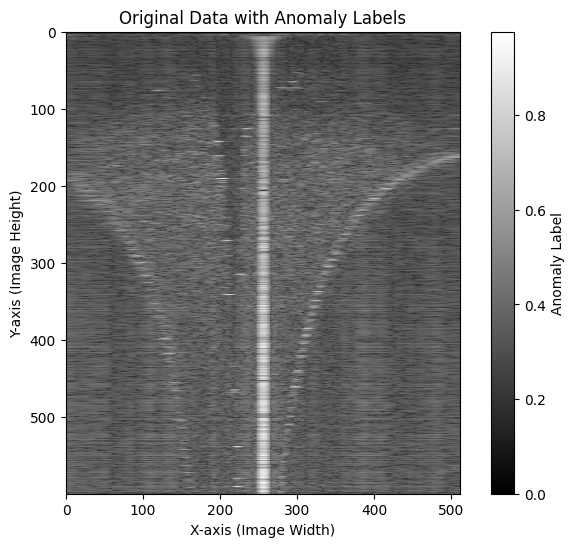

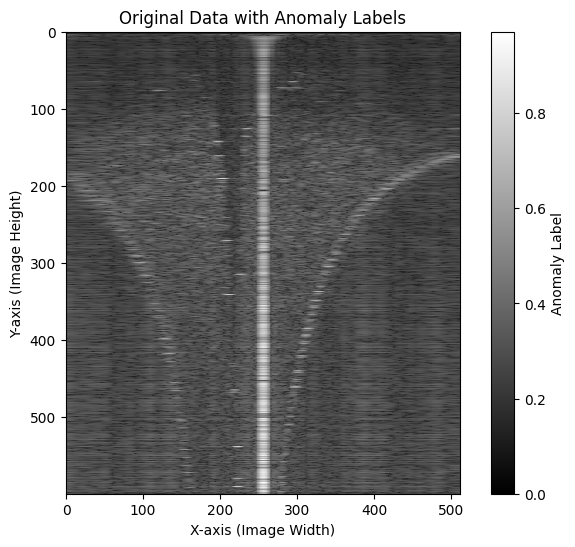

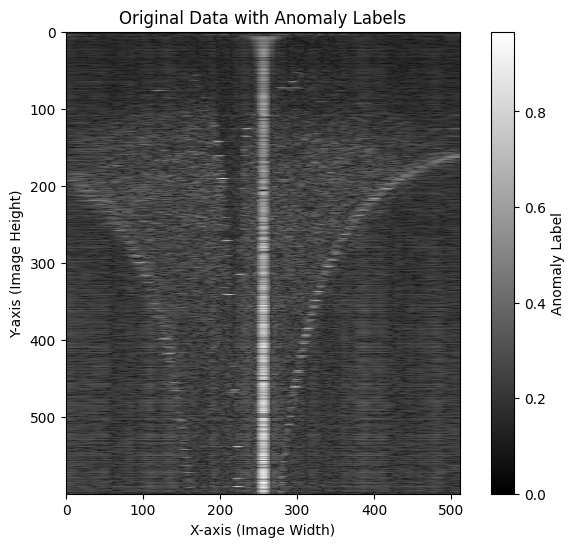

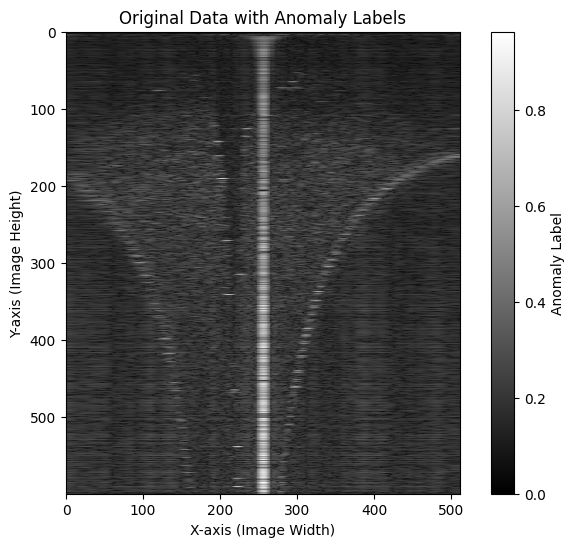

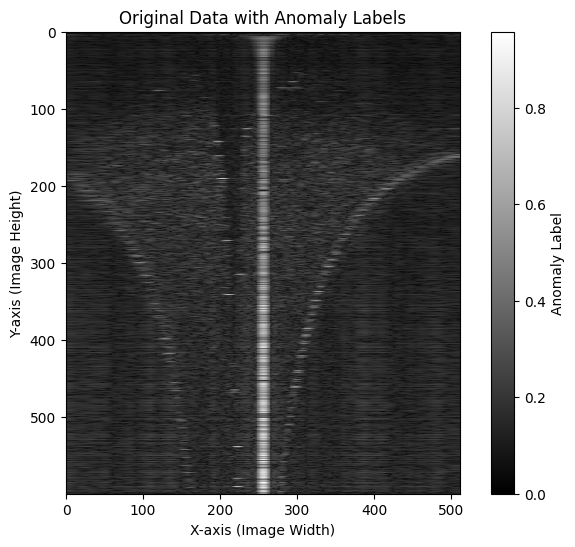

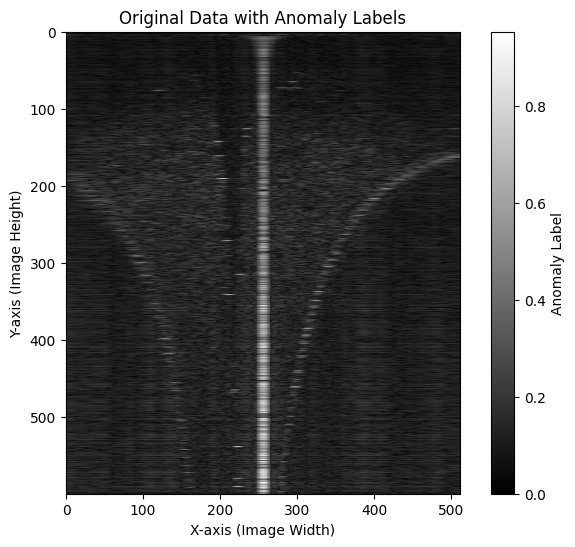

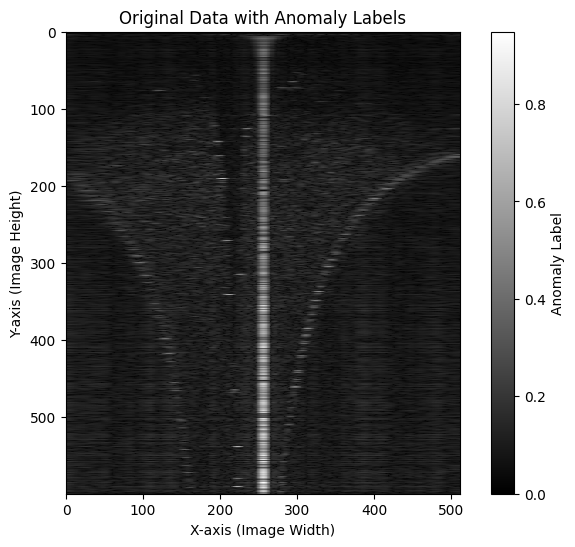

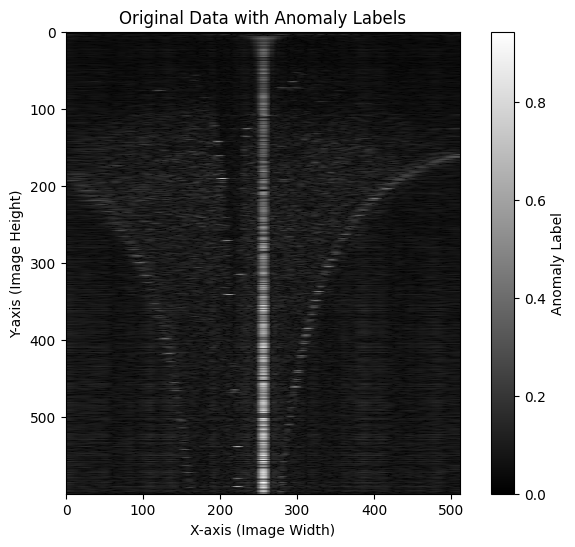

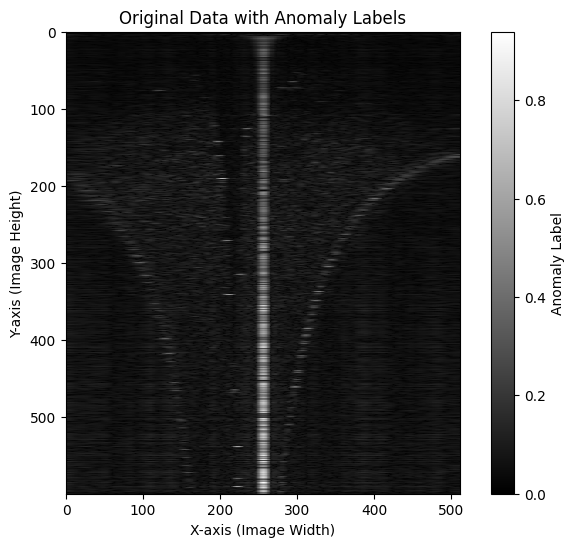

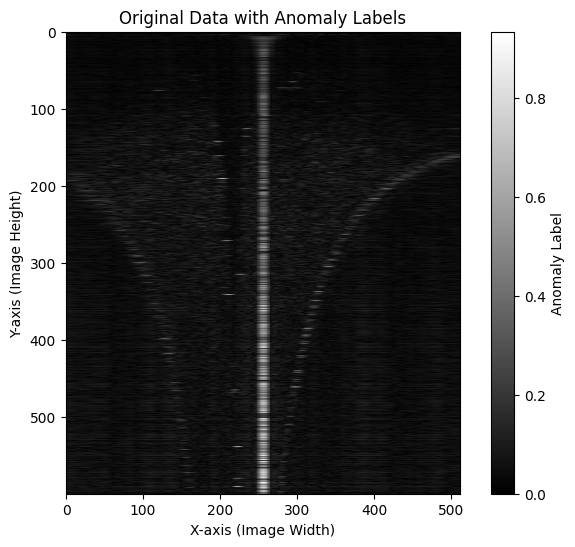

In [118]:
# Read and reshape image data
file_path = "./data/go22-26m.dat"
img_8bit_matrix = read_sonar_data(file_path)
ans = reshape_img_matrix(img_8bit_matrix)  # ans为最后读出来的三维数组
ans_tensor, labels_tensor = prepare_data_and_labels(ans, show_labels=False)
# new_ans_tensor, new_labels_tensor = prepare_data_and_labels(ans)

In [119]:
ans_tensor.shape

torch.Size([1000, 1, 600, 512])

In [121]:
# 初始化卷积网络
conv_net = ConvNet()
# 检查 GPU 是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 加载预训练模型的权重
conv_net.load_state_dict(torch.load('./model/smallmodeland.pth'))
# 将模型移动到 GPU
conv_net.to(device)
# 将数据和标签移动到 GPU
ans_tensor = ans_tensor.to(device)
labels_tensor = labels_tensor.to(device)

In [ ]:
num_epochs = 4
# for i in range(20):
# 开始训练卷积神经网络
train_supervised_model(conv_net, ans_tensor, labels_tensor, num_epochs, learning_rate = 0.01)
# 保存模型参数

Training supervised model...


In [116]:
# 保存模型参数
torch.save(conv_net.state_dict(), "./model/smallmodeland.pth")

In [23]:
# 使用训练后的模型进行预测
conv_net.eval()
with torch.no_grad():
    predictions = conv_net(ans_tensor)

# 交互式显示切片和预测结果
interactive_plot(ans_tensor[0:1], predictions[0:1])


interactive(children=(IntSlider(value=0, description='Slice:', max=19), Output()), _dom_classes=('widget-inter…

In [ ]:
ans_tensor[0:10].shape

In [ ]:
import torch
from torchviz import make_dot

# 创建模型实例
conv_net = ConvNet()

# 生成一个随机输入数据
x = torch.randn(1, 1, 1200, 1024)  # 根据您的输入尺寸进行调整

# 前向传播
y = conv_net(x)

# 可视化计算图
dot = make_dot(y, params=dict(conv_net.named_parameters()))
dot.render("conv_net_architecture", format="png")  # 生成 PNG 文件
